In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

DN="/content/gdrive/MyDrive/Colab/darknet"
print(DN)

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab/darknet


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


class LicensePlateDetector:
    def __init__(self, pth_weights: str, pth_cfg: str, pth_classes: str):
        self.net = cv2.dnn.readNet(pth_weights, pth_cfg)
        self.classes = []
        with open(pth_classes, 'r') as f:
            self.classes = f.read().splitlines()
        self.font = cv2.FONT_HERSHEY_PLAIN
        self.color = (255, 0, 0)
        self.coordinates = None
        self.img = None
        self.fig_image = None
        self.roi_image = None


    def detect(self, img_path: str):
        orig = cv2.imread(img_path)
        self.img = orig
        img = orig.copy()
        height, width, _ = img.shape
        blob = cv2.dnn.blobFromImage(img, 1 / 255, (416, 416), (0, 0, 0), swapRB=True, crop=False)
        self.net.setInput(blob)
        output_layer_names = self.net.getUnconnectedOutLayersNames()
        layer_outputs = self.net.forward(output_layer_names)
        boxes = []
        confidences = []
        class_ids = []

        for output in layer_outputs:
            for detection in output:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.2:
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    boxes.append([x, y, w, h])
                    confidences.append((float(confidence)))
                    class_ids.append(class_id)

        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4)

        if len(indexes) > 0:
            for i in indexes.flatten():
                x, y, w, h = boxes[i]
                label = str(self.classes[class_ids[i]])
                confidence = str(round(confidences[i],2))
                cv2.rectangle(img, (x,y), (x + w, y + h), self.color, 15)
                cv2.putText(img, label + ' ' + confidence, (x, y + 20), self.font, 3, (255, 255, 255), 3)
        self.fig_image = img
        self.coordinates = (x, y, w, h)
        return


    def crop_plate(self):
        x, y, w, h = self.coordinates
        roi = self.img[y:y + h, x:x + w]
        self.roi_image = roi
        return


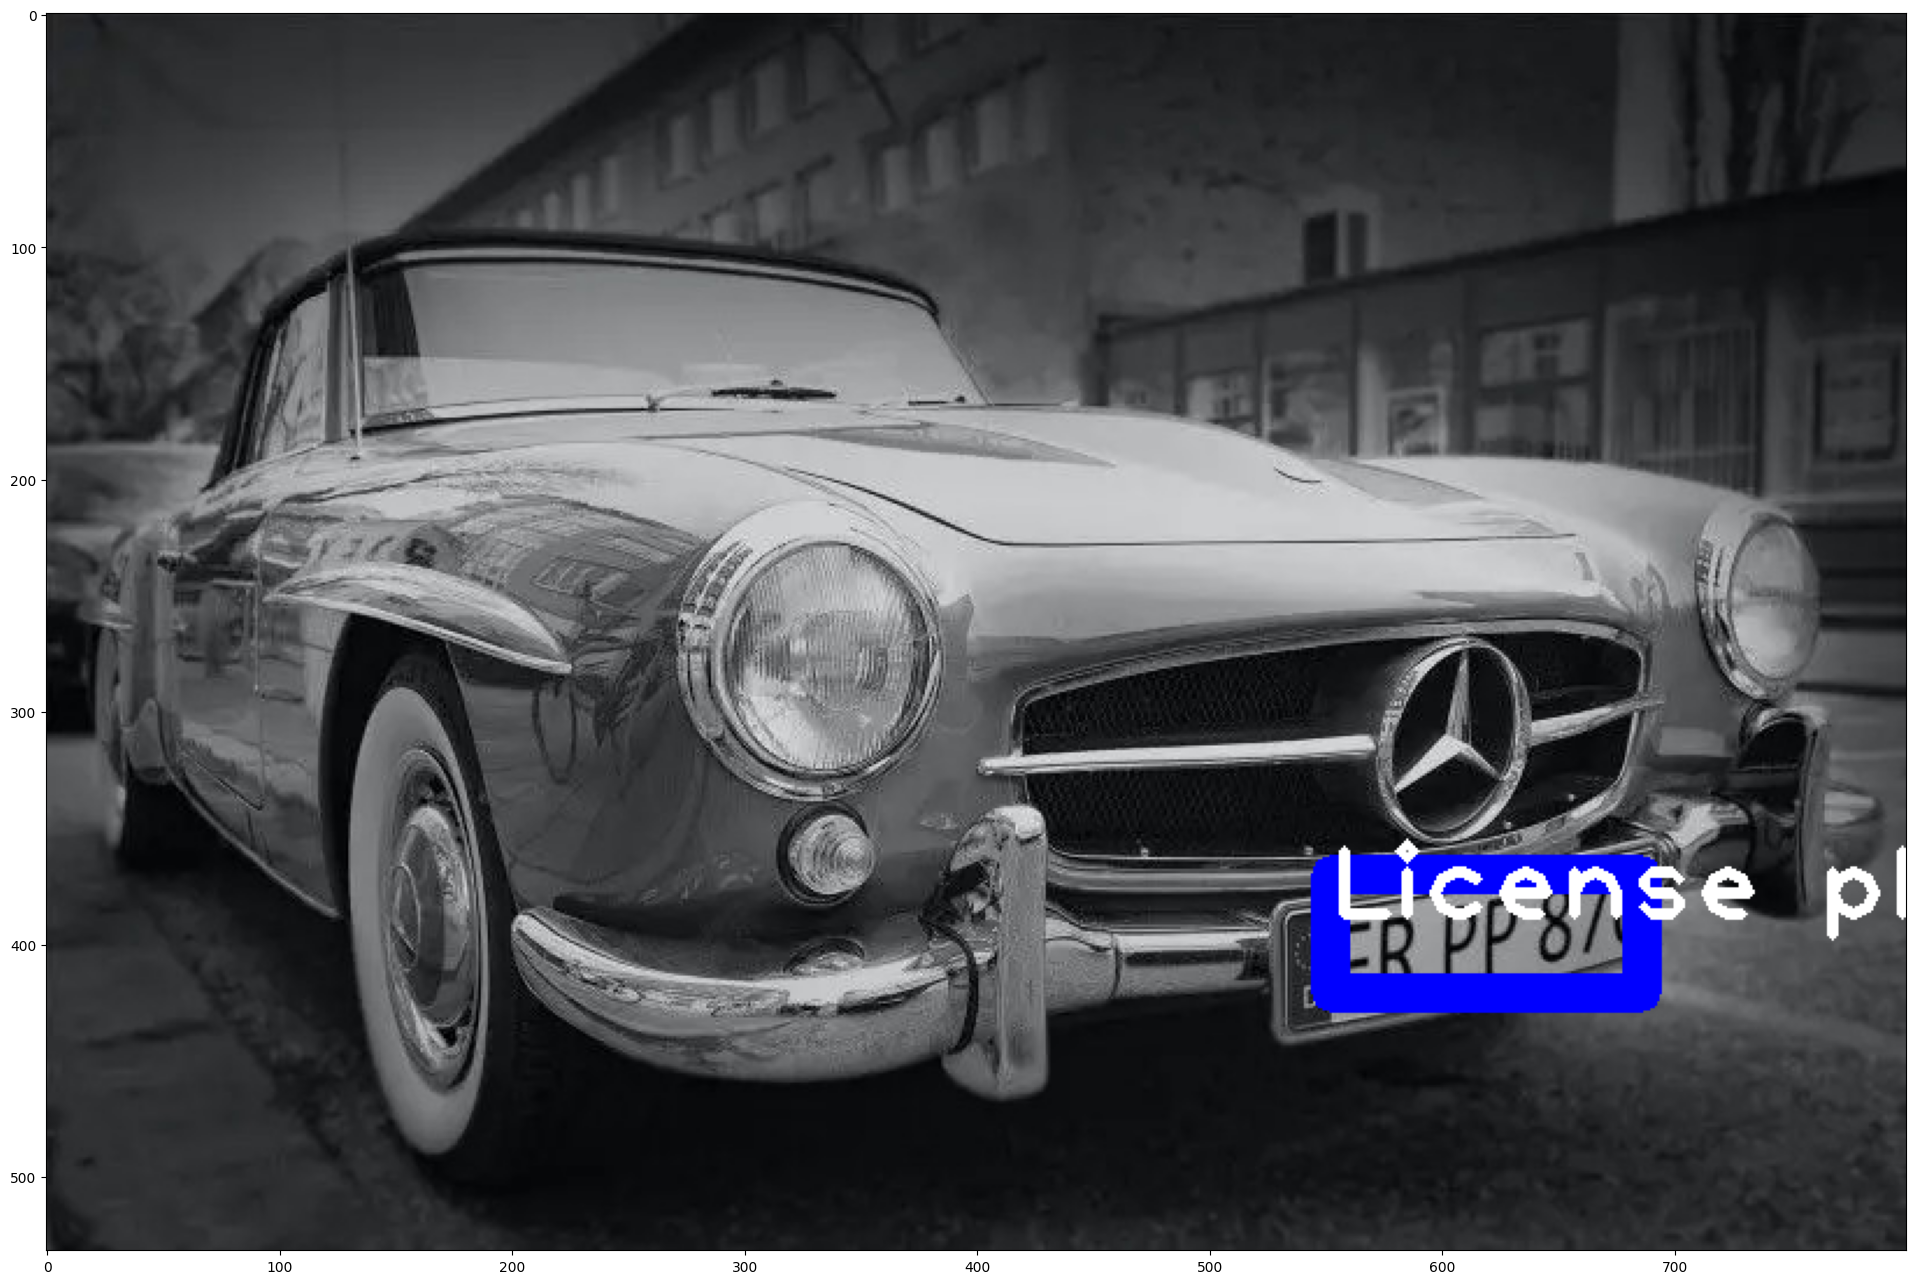

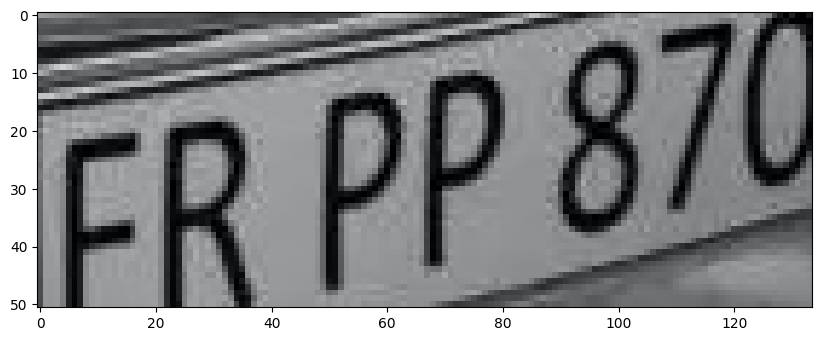

In [4]:
lpd = LicensePlateDetector(
    pth_weights='/content/gdrive/MyDrive/Colab/darknet/backup/yolov3-train_last.weights',
    pth_cfg='/content/gdrive/MyDrive/Colab/darknet/cfg/yolov3-train.cfg',
    pth_classes='/content/gdrive/MyDrive/Colab/darknet/data/cars/classes.txt'
)

# Detect license plate
lpd.detect('/content/gdrive/MyDrive/Colab/Cars/0001.jpg')

# Plot original image with rectangle around the plate
plt.figure(figsize=(24, 24))
plt.imshow(cv2.cvtColor(lpd.fig_image, cv2.COLOR_BGR2RGB))
plt.savefig('/content/gdrive/MyDrive/Colab/Cars/detected.jpg')

# Crop plate and show cropped plate
lpd.crop_plate()
plt.figure(figsize=(10, 4))
plt.imshow(cv2.cvtColor(lpd.roi_image, cv2.COLOR_BGR2RGB))
plt.savefig('/content/gdrive/MyDrive/Colab/Cars/plate.jpg')